In [1]:
import pandas as pd

In [2]:
total_car_registered = pd.read_csv('./total_car_registered.csv')
ev_registered = pd.read_csv('./ev_registered.csv')
h2_registered = pd.read_csv('./h2_registered.csv')

In [3]:
ev_registered['연도'] = ev_registered['년월'].str.split('-').str[0]

ev_registered = ev_registered.groupby('연도')['누적등록대수'].max().reset_index()

ev_registered

,연도,누적등록대수
0,2010,66
1,2011,344
2,2012,860
3,2013,1464
4,2014,2775
5,2015,5712
6,2016,10855
7,2017,25108
8,2018,55756
9,2019,89918


In [4]:
h2_registered

,연도,누적등록대수
0,2018,893
1,2019,5083
2,2020,10906
3,2021,19404
4,2022,29623
5,2023,34258


In [5]:
total_car_registered

,연도,누적등록대수
0,1966,50000
1,1967,60000
2,1968,80000
3,1969,110000
4,1970,130000
5,1971,140000
6,1972,150000
7,1973,170000
8,1974,180000
9,1975,190000


In [6]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

In [7]:
M = total_car_registered['누적등록대수'].max()

In [8]:
total_car_starts_at = total_car_registered['연도'].min().astype(int)
ev_starts_at = int(ev_registered['연도'].min())
h2_starts_at = h2_registered['연도'].min().astype(int)

ev_starts_at, h2_starts_at, total_car_starts_at

(2010, 2018, 1966)

In [9]:
def bass_model(t, p, q, m):
    return m * ((1 - np.exp(-(p + q) * t)) / (1 + (q / p) * np.exp(-(p + q) * t)))

def innovators(t, p, q, m):
    return p * m * (np.exp(-(p + q) * t) / (1 + (q / p) * np.exp(-(p + q) * t)))

def imitators(t, p, q, m):
    return q * m * (np.exp(-(p + q) * t) / (1 + (q / p) * np.exp(-(p + q) * t))) * (bass_model(t, p, q, m) / m)


def fit_bass_model(time, cumulative_data, p0=[0.03, 0.3, M]):
    params, _ = curve_fit(
        bass_model, time, cumulative_data, p0=p0, method='lm', maxfev=1000000
    )
    p_opt, q_opt, m_opt = params
    print(f"Optimal P value: {p_opt}")
    print(f"Optimal Q value: {q_opt}")
    print(f"Optimal M value: {m_opt}")
    return params

ev_params = fit_bass_model(np.arange(len(ev_registered)), ev_registered['누적등록대수'].values, [0.03, 0.3, M])
h2_params = fit_bass_model(np.arange(len(h2_registered)), h2_registered['누적등록대수'].values, [0.01, 0.3, M])
total_car_params = fit_bass_model(np.arange(len(total_car_registered)), total_car_registered['누적등록대수'].values, [0.03, 0.3, M])

Optimal P value: 5.6647771780720876e-05
Optimal Q value: 0.8354187926750044
Optimal M value: 644379.3043671476
Optimal P value: 0.07317272372156337
Optimal Q value: 0.7481777266241139
Optimal M value: 41166.80788463759
Optimal P value: 0.0012024955592953228
Optimal Q value: 0.12827313929738032
Optimal M value: 25966086.939930405


In [10]:
def predict_plot(params, starts_at, predict_range):
    p, q, m = params
    future_time = np.arange(0, predict_range)
    predicted_adopters = bass_model(
        future_time, p, q, m
    )

    plt.plot([i for i in range(starts_at, starts_at + predict_range)], predicted_adopters)
    plt.axvline(x=2024, color='red', linestyle='--')


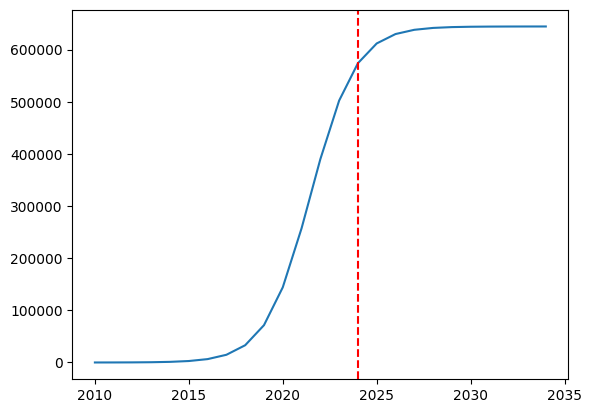

In [11]:
predict_plot(ev_params, ev_starts_at, 25)

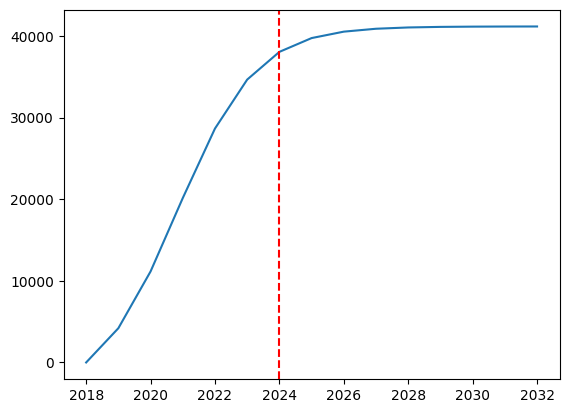

In [12]:
predict_plot(h2_params, h2_starts_at, 15)

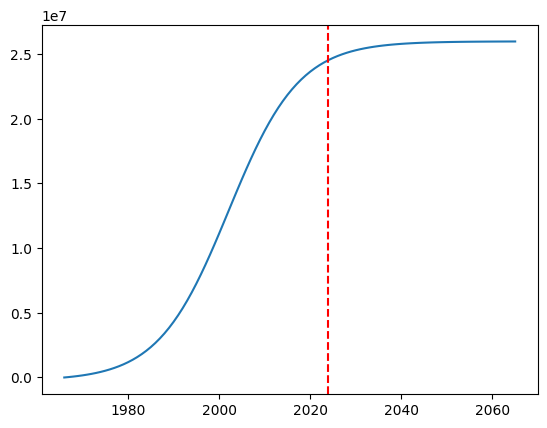

In [13]:
predict_plot(total_car_params, total_car_starts_at, 100)